In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from datetime import datetime
import time
import seaborn

In [26]:
os.chdir(r'C:\Users\USER\Desktop\Dynamic pricing')

product = pd.read_csv('pruduct.csv', encoding='utf-8')
session = pd.read_csv('Session.csv', encoding='utf-8')
search1 = pd.read_csv('Search1.csv', encoding='utf-8')
search2 = pd.read_csv('Search2.csv', encoding='utf-8')
custom =  pd.read_csv('custom.csv', encoding='utf-8')
master =  pd.read_csv('Master.csv', encoding='utf-8')

C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
## 'Product' preprocessing

# 브랜드 변수에서 특수문자 제거
product['PD_BRA_NM'] = list(map(lambda x:re.sub("[[,\](,)\s]", "", x), product['PD_BRA_NM']))

# 구매가격 변수를 str -> int 변환.
product['PD_BUY_AM'] = list(map(lambda x:x.replace(",",""),product['PD_BUY_AM']))
product['PD_BUY_AM'] = product['PD_BUY_AM'].astype(int)

# 구매개수 변수를 str&int -> int로 변환.
product['PD_BUY_CT'] = product['PD_BUY_CT'].astype(str)
product['PD_BUY_CT'] = list(map(lambda x:x.replace(",",""),product['PD_BUY_CT']))
product['PD_BUY_CT'] = product['PD_BUY_CT'].astype(int)

# product를 CLNT_ID 순으로 정렬
product = product.sort_values(by=['CLNT_ID'], axis=0)

#product에 새로운 열 "TOT_AM" 생성 (PD_BUY_AM는 제품 하나 당 개수이므로, 이를 구매한 제품의 갯수와 곱한 "총 지출 금액"이 "TOT_AM"임)
product["TOT_AM"] = product["PD_BUY_AM"] * product["PD_BUY_CT"]

# CLNT_ID와 SESS_ID가 모두 같은 행들을 "TOT_AM","PD_BUY_CT","PD_BUY_AM"에 대해 합계,평균,표준편차를 구한 것
product_agg = product.groupby(['CLNT_ID', 'SESS_ID'])[['TOT_AM','PD_BUY_CT','PD_BUY_AM']].agg(['sum','mean'])
product_agg.columns= list(map(lambda x:x[0]+'_'+x[1],list(product_agg)))

In [28]:
## 'Session' preprocessing
# SESS_DT을 datetime 자료형으로 변환.
session['SESS_DT'] = pd.to_datetime(session['SESS_DT'], format = '%Y%m%d')
# 월,주,일 변수 생성. 19 -> 1월 1일 이후 19번째 주 double check  0 = 월요일, 6 = 일요일  double check
session['MONTH'] = list(map(lambda x:x.month,session['SESS_DT'])) 
session['WEEK'] = list(map(lambda x:x.week,session['SESS_DT'])) 
session['DAY'] = list(map(lambda x:x.weekday(),session['SESS_DT'])) 

In [29]:
## 'search 1,2' preprocessing 

# merge를 위해 SESS_DT 형식 동일하게 변경. 
search2['SESS_DT'] = pd.to_datetime(search2['SESS_DT'], format = '%Y%m%d')

# 검색량 변수를 str&int -> int로 변환 후 이름 변경.
search2['SEARCH_CNT'] = search2['SEARCH_CNT'].astype(str)
search2['SEARCH_CNT'] = list(map(lambda x:x.replace(",",""), search2['SEARCH_CNT']))
search2['SEARCH_CNT'] =  search2['SEARCH_CNT'].astype(int)
search2.rename(columns={'SEARCH_CNT': 'SEARCH_TOT'}, inplace=True) # Search1과 컬럼명이 동일하지만 의미가 다르므로 이름 변경.

# 전체검색량, 검색 키워드 갯수, 개인검색량, 전체검색량 대비 개인 검색량, 변수 생성.
search = pd.merge(search1,session.loc[:,['CLNT_ID','SESS_ID','SESS_DT']],how = 'left', on = ['CLNT_ID','SESS_ID']) 
search = pd.merge(search,search2.loc[:,['SESS_DT','KWD_NM','SEARCH_TOT']],how = 'left', on = ['KWD_NM','SESS_DT']) 
cnt = search.groupby(['CLNT_ID','SESS_ID']).count()['KWD_NM'] # 순서 유의.
search = search.groupby(['CLNT_ID','SESS_ID']).sum() # 이 부분에서 고유한 키값으로 줄어듬. 
search['KWD_CNT'] = cnt
search['SEARCH_RATIO'] = search.SEARCH_CNT / search.SEARCH_TOT  

In [30]:
## y labeling
# 날짜 차이 구하기
session = session.sort_values(['CLNT_ID','SESS_DT']) # diff를 사용하기 위해 날짜순으로 정렬
session['DT_DIFF'] = session['SESS_DT'].diff() # (1) 일단은 전체에 대해 차이를 구해준 다음
session.loc[session.CLNT_ID != session.CLNT_ID.shift(),'DT_DIFF'] = None #(2) CLNT_ID가 변하는 경우에만 None로 수정
# 새롭게 라벨 제작
Y = session['DT_DIFF'].dt.days.tolist() # date 형태를 int 형태로 변형
a = list()
a.append(np.nan)
Y = Y[1:]+a # 한칸씩 올리고 마지막에 np.nan 추가 
session['Y']=Y #라벨 추가
session = session[pd.notnull(session['Y'])] # 라벨값이 np.nan인경우

In [32]:
session.shape

(1790170, 14)

In [33]:
## merge


raw = pd.merge(session,custom, how = 'left', on = ['CLNT_ID']) 
raw = pd.merge(raw,product_agg, how = 'left', on = ['CLNT_ID','SESS_ID']) 
raw = pd.merge(raw,search,how = 'left', on = ['CLNT_ID','SESS_ID']) 

raw = raw.reindex(columns=sorted(list(raw)))

In [36]:
import pickle
with open('C:/Users/USER/Desktop/Dynamic/raw.pickle', 'wb') as f:
    pickle.dump(raw, f)



In [9]:
## EDA



In [37]:
#날짜 차이를 기준으로 그룹형성 -> 갯수(size) 구하기 -> index제거
test=raw.groupby('DT_DIFF',as_index=False).size().reset_index(name = 'count')

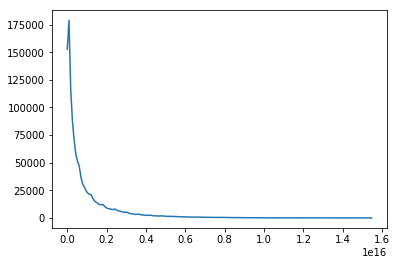

In [38]:
import matplotlib.pyplot as plt 
plt.plot(test['DT_DIFF'],test['count'])

In [40]:
#EDA#하루에도 다른 세션ID로 여러번 구매하신 경우가 있을까? 각 클라이언트별 구매날짜횟수와 SESS_ID횟수 비교
a = raw.groupby('CLNT_ID')['SESS_DT'].nunique()
b = raw.groupby('CLNT_ID')['SESS_ID'].nunique()

In [41]:
c = b-a
sum(c) 
# 구매날짜와 SSES_ID 횟수에 차이가 없다는 것으로 보아 하루에 다른 세션으로 여러번 구매한 경우 없음 . 
#아마도/어쩌면 세션은 하루에 하나만 발급일지도 모르긴하지만..
# 따라서 0일만에 재구매한 고객은 없으므로 재구매 기준은 1일부터 

152620

In [42]:
test

,DT_DIFF,count
0,0 days,152620
1,1 days,178927
2,2 days,116730
3,3 days,88425
4,4 days,70419
5,5 days,57819
6,6 days,51327
7,7 days,47058
8,8 days,37141
9,9 days,31060


In [43]:
def findSplitPoint(test, n) : 
   
    left = list()
    right = list()
    splitpoint = list()
    
    leftSum = 0 
    # traverse array element 
    for i in range(0, n) : 
       
        # add current element to left Sum 
        leftSum += test.iloc[i,1]  
        left.append(leftSum)
        splitpoint.append(i+1)
        # find sum of rest array elements (rightSum) 
        rightSum = 0 
        for j in range(i+1, n) : 
            rightSum += test.iloc[j,1]
        
        right.append(rightSum)
    # split poindex 
    return left,right,splitpoint
   

In [45]:
left,right,splitpoint = findSplitPoint(test,180)

In [46]:
Decider =pd.DataFrame(np.vstack([splitpoint,left, right]).T,
              columns=['splitpoint','leftsum', 'rightsum'])

In [47]:
Decider

,splitpoint,leftsum,rightsum
0,1,152620,1087465
1,2,331547,908538
2,3,448277,791808
3,4,536702,703383
4,5,607121,632964
5,6,664940,575145
6,7,716267,523818
7,8,763325,476760
8,9,800466,439619
9,10,831526,408559


In [ ]:
print("hello")